In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
ticker = 'AAPL'
df = yf.download(ticker, start='2020-01-01')

/var/folders/yv/vh7rldds4k9bqhgcldmc2h580000gn/T/ipykernel_70626/3142132640.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2020-01-01')
[*********************100%***********************]  1 of 1 completed


In [6]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.620850,72.681296,71.373226,71.627100,135480400
2020-01-03,71.914848,72.676477,71.689988,71.847148,146322800
2020-01-06,72.487839,72.526526,70.783241,71.034702,118387200
2020-01-07,72.146942,72.753823,71.926915,72.497529,108872000
2020-01-08,73.307510,73.609745,71.849533,71.849533,132079200
...,...,...,...,...,...
2025-06-09,201.449997,206.000000,200.020004,204.389999,72862600
2025-06-10,202.669998,204.350006,200.570007,200.600006,54672600


<Axes: xlabel='Date'>

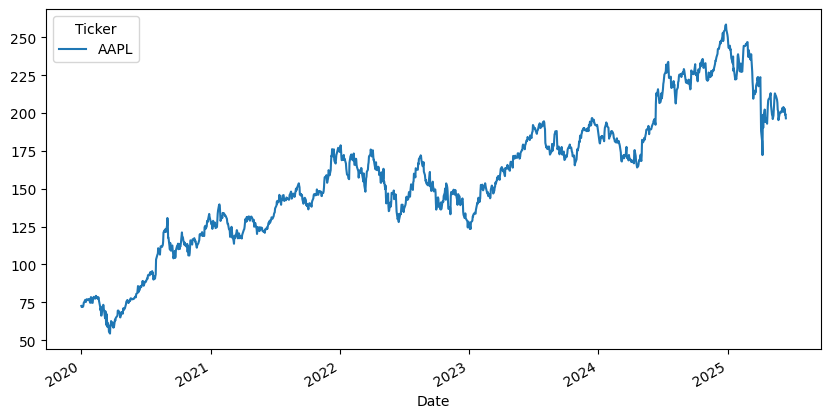

In [8]:
df.Close.plot(figsize=(10,5))

In [26]:
scaler = StandardScaler()

df["Close"] = scaler.fit_transform(df["Close"])

In [27]:
len(df)

1370

In [45]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    # data.append(df[i:i+seq_length])
    data.append(df["Close"].values[i:i+seq_length])

data = np.array(data)
if data.ndim == 2:
    data = data.reshape((data.shape[0], data.shape[1], 1))

In [46]:
data

array([[[-1.90941288],
        [-1.92532212],
        [-1.91241019],
        ...,
        [-1.80034199],
        [-1.7588898 ],
        [-1.77161485]],

       [[-1.92532212],
        [-1.91241019],
        [-1.92009205],
        ...,
        [-1.7588898 ],
        [-1.77161485],
        [-1.77117799]],

       [[-1.91241019],
        [-1.92009205],
        [-1.89393946],
        ...,
        [-1.77161485],
        [-1.77117799],
        [-1.80367368]],

       ...,

       [[ 1.20736289],
        [ 1.23639416],
        [ 1.25484804],
        ...,
        [ 1.04932093],
        [ 0.99366119],
        [ 1.02115306]],

       [[ 1.23639416],
        [ 1.25484804],
        [ 1.07548486],
        ...,
        [ 0.99366119],
        [ 1.02115306],
        [ 0.93349466]],

       [[ 1.25484804],
        [ 1.07548486],
        [ 0.930104  ],
        ...,
        [ 1.02115306],
        [ 0.93349466],
        [ 0.94295903]]])

In [47]:
# train_size = int(0.8 * len(data))

# X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.FloatTensor).to(device)
# y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.FloatTensor).to(device)

# X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.FloatTensor).to(device)
# y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.FloatTensor).to(device)

# Train-test split
train_size = int(0.8 * len(data))
X_train = torch.from_numpy(data[:train_size, :-1, :]).float().to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).float().to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).float().to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).float().to(device)

In [48]:
class PredictionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(PredictionModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [49]:
# model = PredictionModel(input_size=5, hidden_size=32, num_layers=2, output_size=1).to(device)
model = PredictionModel(input_size=1, hidden_size=32, num_layers=2, output_size=1).to(device)


In [50]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [51]:
num_epochs = 200

for i in range(num_epochs):
    y_train_pred = model(X_train)
    loss = criterion(y_train_pred, y_train)

    if i % 25 == 0:
        print(f'Epoch {i}, loss: {loss}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch 0, loss: 0.675491213798523
Epoch 25, loss: 0.01380599569529295
Epoch 50, loss: 0.006281182169914246
Epoch 75, loss: 0.005584247875958681
Epoch 100, loss: 0.0052595664747059345
Epoch 125, loss: 0.004984281025826931
Epoch 150, loss: 0.004726814106106758
Epoch 175, loss: 0.004485288634896278
